In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

import quandl
from tqdm import tqdm
from itertools import combinations
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = './data/raw_data.csv'
data = pd.read_csv(file_name)
data.date = pd.to_datetime(data.date)
# data.rename(columns={'adj_close':'price'}, inplace=True)
data = data.set_index("date")
data.sort_index(inplace = True)
data.head()

,None,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,,
1993-01-29,7567,SPY,43.9687,43.9687,43.7500,43.9375,1003200.0,0.0,1.0,25.219734,25.219734,25.094291,25.201838,1003200.0
1993-02-01,7566,SPY,43.9687,44.2500,43.9687,44.2500,480500.0,0.0,1.0,25.219734,25.381083,25.219734,25.381083,480500.0
1993-02-02,7565,SPY,44.2187,44.3750,44.1250,44.3437,201300.0,0.0,1.0,25.363130,25.452781,25.309385,25.434828,201300.0
1993-02-03,7564,SPY,44.4062,44.8437,44.3750,44.8125,529400.0,0.0,1.0,25.470677,25.721620,25.452781,25.703724,529400.0
1993-02-04,7563,SPY,44.9687,45.0937,44.4687,45.0000,531500.0,0.0,1.0,25.793318,25.865016,25.506526,25.811271,531500.0


In [3]:
tickers = ['MGC', 'VONE', 'VOO', 'RSP', 'SPY', 'VV', 'IWV', 'FEX', 'IVV', 'ITOT', 'IYY', 'IWB', 'VTI', 'SCHB']
years = data.index.year.unique()

### Cointegrated Pairs

In [4]:
def get_sample(y, pair = None):
    y_start, y_train, y_end = y-2, y, y+1
    temp = data.loc[str(y_start):str(y_end)].pivot_table(index='date', columns='ticker', values='adj_close')
    if pair:
        temp = temp.loc[:,pair]
    ret = np.log(temp/temp.iloc[0])
    temp_in = temp.loc[str(y_start):str(y_train-1)]
    temp_out = temp.loc[str(y_train):str(y_end-1)]
    ret_in = ret.loc[str(y_start):str(y_train-1)]
    ret_out = ret.loc[str(y_train):str(y_end-1)]
    return temp_in, temp_out, ret_in, ret_out

In [43]:
y = 2019
pair = ['VV','SPY']
price_in, price_out, ret_in, ret_out = get_sample(y, pair)

In [48]:
sp500 = pd.read_csv('./data/sp500.csv', parse_dates=['Date'], index_col='Date')['Price'].sort_index().str.replace(',','').astype(float).pct_change()
vix = pd.read_csv('./data/vix.csv', parse_dates=['Date'], index_col='Date')['Price'].sort_index().diff()
x = pd.concat([sp500, vix], axis=1)
x.columns = ['sp500', 'vix']

z_in = x.loc[price_in.index]
z_out = x.loc[price_out.index]

In [ ]:
x

In [14]:
def adf_valid_test(y):
    adf_res = ts.adfuller(y, regression = 'n')
    print(adf_res)
    if adf_res[1] < 0.05:
        return True
    return False


In [15]:
a = [-10.41, -3.44, -2.86, -2.57]
b = [-12.2, -3.44, -2.85, -2.57]
pd.DataFrame([a,b], columns=['ADF', '1%', '5%', '10%'], index=['S&P500', 'VIX']).to_latex('./writeups/covariate_adf.tex')


In [16]:
adf_valid_test(x.sp500)

(-5.4202247509292985, 1.5271961132798757e-07, 16, 485, {'1%': -2.5703653161866296, '5%': -1.9415678462012134, '10%': -1.6162836866961112}, -3266.989184814496)


True

In [17]:
adf_valid_test(x.vix)

(-10.360125157806358, 1.6376871404370329e-18, 7, 494, {'1%': -2.5702807734924353, '5%': -1.9415572546490951, '10%': -1.6162932590923897}, 1844.792662795965)


True

<AxesSubplot: xlabel='date'>

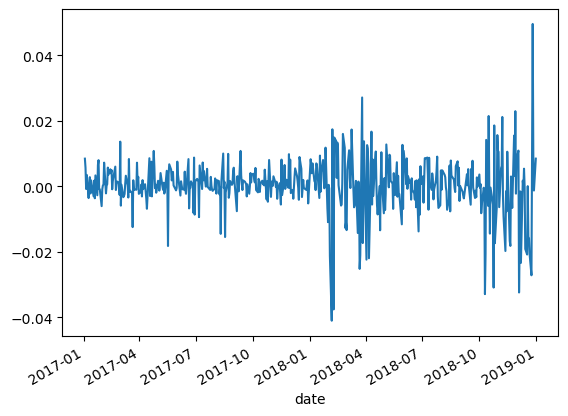

In [18]:
x.iloc[:,0].plot()

<AxesSubplot: xlabel='date'>

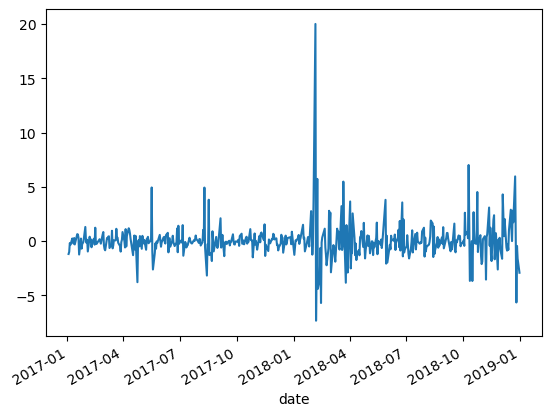

In [19]:
x.iloc[:,1].plot()

In [22]:
x_train, y_train = price_in[pair[0]], price_in[pair[1]]
x_test, y_test = price_out[pair[0]], price_out[pair[1]]

### Kernel Estimation

In [33]:
import statsmodels.nonparametric.bandwidths as bw
import statsmodels.api as sm
import scipy.stats as stats

def normal_pdf(x, scale = 2.5, const = 1):
    return np.exp(-0.5 * (x*scale)**2) / const

def gaussian_kernel(x, ker_x):
    h = bw.bw_scott(ker_x)
    kernel_val = normal_pdf((x - ker_x)/h) / h
    return kernel_val

def kernel_regresssion(z, x_train, y_train, z_train):
    z = np.asarray(z)
    num_prep = x_train * y_train
    den_prep = x_train **2
    print(z.shape)
    def kernel(z):
        w = gaussian_kernel(z, z_train)
        return np.sum(num_prep * w) / np.sum(den_prep * w)
    kernel = np.vectorize(kernel)
    return kernel(z)

def get_max_chi_pval(p, k, m, nboot = int(1e4)):
    chi_cval = np.zeros(nboot)
    chi_cval.sort()
    for i in range(nboot):
        chi_cval[i] = np.random.chisquare(k, m).max()
    
    p1_ind, p5_ind, p10_ind = int(1e4 * 0.01), int(1e4 * 0.05), int(1e4 * 0.1)
    cval = [chi_cval[p1_ind], chi_cval[p5_ind], chi_cval[p10_ind]]
    return (chi_cval > p).mean(), cval


u_range = np.arange(-1, 1, 1e-5)
def stability_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(x_train)
    h = bw.bw_scott(z_train)
    
    sig_u = u.var()
    xt_2 = x_train **2
    deno_prep = np.vectorize(lambda z: 1/n**2 * np.sum(gaussian_kernel(z, z_train) * xt_2))
    deno = deno_prep(z_train)
    nu0 = np.sum(normal_pdf(u_range) ** 2) * 1e-5
    omega = sig_u * nu0/deno
    
    T = n**2 * np.sqrt(h) * (betas - beta_const) / np.sqrt(omega) # Is m * 1 vector where m = len(z_train)
    Tm = abs(T).max()
    pval, cval = get_max_chi_pval(Tm, 1, n)
    return Tm, pval, cval


def coint_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(u)
    time = np.arange(n)
    mod = sm.OLS(u**2, sm.add_constant(time)).fit()
    b_hat = mod.params[1]
    global u2, u2_mean
    u2 = u**2
    u2_mean = u2.mean()
    
    u2_dem = u2 - u2_mean
    M = int(np.sqrt(n))
    def khM_ch(h):
        if h != 0:
            return normal_pdf(h/M) * np.sum((u2.iloc[:-h] - u2_mean).values * (u2.iloc[h:] - u2_mean).values)/n
        else: 
            return normal_pdf(h/M) * np.sum((u2 - u2_mean).values * (u2 - u2_mean).values)/n
    omega_val = np.vectorize(khM_ch)
    M_range = np.arange(-M, M)
    omega2 = np.sum(omega_val(M_range))
    t_sum = time.var() * n
    s_b = np.sqrt(omega2/t_sum)
    t = b_hat/s_b
    pval = 1-stats.norm(0,1).cdf(abs(t))
    cval = stats.norm(0,1).ppf([0.01, 0.05, 0.1])
    return t, pval, cval

In [24]:
stability_test(x_train, y_train, z_in.sp500), coint_test(x_train, y_train, z_in.sp500)

((1447.1560064207108,
  0.0,
  [10.32666576611448, 7.096720872181698, 9.925431211313438]),
 (-1.2601904374082558,
  0.10380033582542014,
  array([-2.32634787, -1.64485363, -1.28155157])))

In [25]:
h = 0
np.sum((u2.iloc[:-h] - u2_mean).values * (u2.iloc[h:]**2 - u2_mean).values)

ValueError: operands could not be broadcast together with shapes (0,) (502,) 

In [204]:
a = ['S&P500', 1447.15, 7.75, 12.93, 9.22]
b = ['S&P500', -1.26, -2.32, -1.64, -1.28]
c = ['VIX', 1862.94, 8.03, 8.97, 11.70]
d = ['VIX', -1.43, -2.32, -1.64, -1.28]
kk = pd.DataFrame([a,b,c,d], columns=['Covariate','Test Statistics', '1%', '5%', '10%'], index=['Stability', 'Cointegration', 'Stability','Cointegration'])

In [205]:
kk.reset_index(names = 'Type').set_index(['Covariate', 'Type']).to_latex('./writeups/covariate_test.tex')

In [34]:
stability_test(x_train, y_train, z_in.sp500), coint_test(x_train, y_train, z_in.sp500)

(502,)
(502,)


((1447.1560064207108,
  0.0,
  [10.60467199412117, 12.88258203237084, 8.755611942666079]),
 (-1.2601904374082558,
  0.10380033582542014,
  array([-2.32634787, -1.64485363, -1.28155157])))

Series([], Name: vix, dtype: float64)

(252,)


<AxesSubplot: >

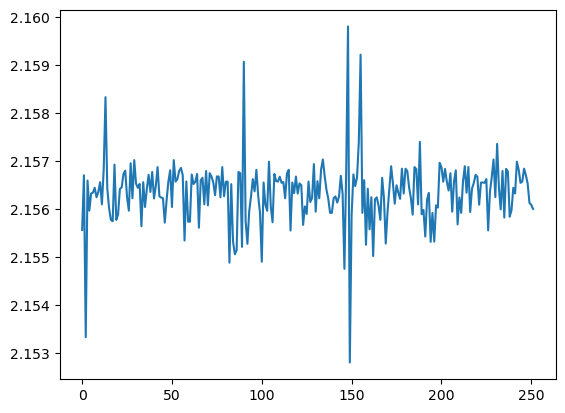

In [50]:
jump = 14
beta = kernel_regresssion(z_out.vix.shift(jump), x_train, y_train, z_in.vix)
pd.Series(beta).plot()

In [75]:
hedge_ratio = pd.DataFrame(np.array([-beta, np.ones(len(beta))]).T[jump:], index = price_out.index)

In [70]:
beta_old = price_in.cov().iloc[0,1]/price_in.var().iloc[0]

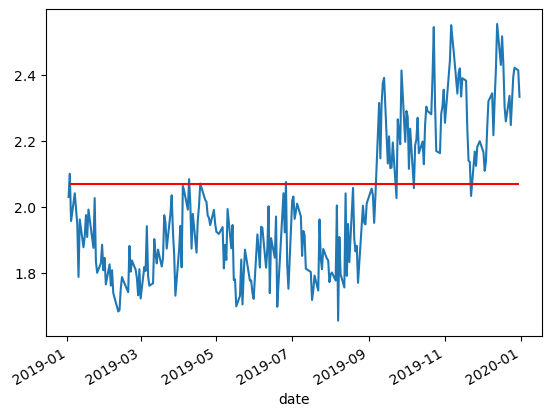

In [74]:
(price_out @ [-beta_old, 1]).plot()
plt.hlines((price_in @ [-beta_old, 1]).mean(), price_out.index[0], price_out.index[-1], color='r')

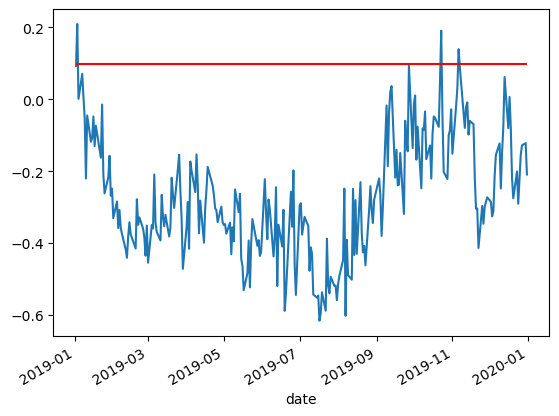

In [73]:
(price_out @ hedge_ratio.iloc[0].values).plot()
plt.hlines((price_in @ hedge_ratio.iloc[0].values).mean(), price_out.index[0], price_out.index[-1], color='r')

In [78]:
hedge_ratio_base = pd.DataFrame(index = price_out.index)

In [80]:
hedge_ratio_monthly = pd.merge_asof(hedge_ratio_base, hedge_ratio.resample('M').first(), left_index=True, right_index=True, direction='forward')

In [84]:
price_out.iloc[jump:] * hedge_ratio_monthly.values

ticker,VV,SPY
date,,
2019-01-02,-233.852816,233.945102
2019-01-03,-228.153060,228.362512
2019-01-04,-236.010580,236.011689
2019-01-07,-237.801932,237.872552
2019-01-08,-240.102190,240.107458
...,...,...
2019-12-24,-306.612546,306.067507
2019-12-26,-308.108318,307.696793
2019-12-27,-308.004445,307.620569


<AxesSubplot: xlabel='date'>

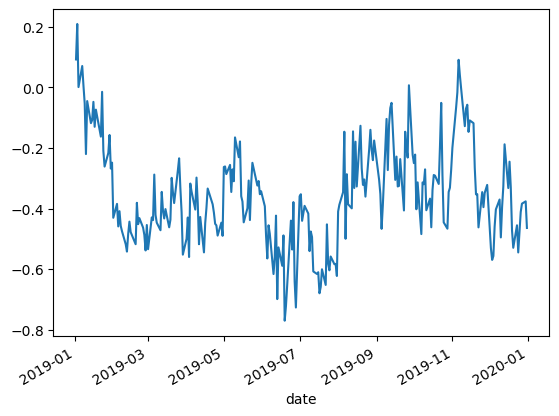

In [85]:
beta_spread = (price_out.iloc[jump:] * hedge_ratio_monthly.values).sum(axis=1)
beta_spread.plot()

In [211]:
adf_valid_test(beta_spread)

(-2.4066915693638347, 0.13985666309007772, 6, 231, {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}, -252.27922719345668)


False

In [212]:
a = [-3.19, -3.45, -2.87, -2.57]
b = [-2.4, -3.45, -2.87, -2.57]
pd.DataFrame([a,b], columns=['ADF', '1%', '5%', '10%'], index=['S&P500', 'VIX']).to_latex('./writeups/spread_adf.tex')